# Create a Video from a Script and Images

This notebook pulls data from an Excel file containing a list of influential figures. It is able to convert text into speech and then combine this with images to produce a video ready for YouTube. The section at the end also allows the user to create a thumbnail for the video and produces a description from a template.

The scripts have been generated using ChatGPT with the prompt "Generate 10 pretty long and interesting facts about \<Influential Figure>". If a script is generated but no audio available then the code will create an audio file based on the script and a pre-made intro and outro. The user must add picutres to a folder of the figure and if they are available but no video produced then the code will calculate a duration for all images and create a video from these images and the audio clip.

Once that is done the video will be saved to the Videos folder but a copy will be in the main repository for ease when uploading to YouTube. You then can make a thumbnail out of images in the respective figures Images file or a seperate image before adding text to the image to make it stand out. A description is also returned for easy uploading.

## Load modules

In [200]:
import pandas as pd
import numpy as np
import os # Check folder contents
import shutil # Move thumbnail
import docx2txt # Import word files
import openpyxl # Save files to Excel
import random # For thumbnail
from PIL import Image, ImageFont, ImageDraw, ImageFilter # Resizing thumbnail and adding text

## Load/Prepare Data Files

### Set Locations

Here we set all of the locations for the data as well as loading in the pre-made Intro, Description, and Outro.

In [201]:
script_loc = "./Scripts/"
images_loc = "./Images/"
set_scripts_loc = "./Set Scripts/"
audio_loc = "./Audio/"
video_loc = "./Video/"

# Get the Intro
intro = docx2txt.process(set_scripts_loc + 'Intro.docx')

# Get the Description
description = docx2txt.process(set_scripts_loc + 'Description.docx')

# Get the Outro
outro = docx2txt.process(set_scripts_loc + 'Outro.docx')

### Load the dataframe of information

Here we load in the dataframe containing the information on the influential figures before adding the prompt and making sure we have no duplicates in the names. We the overwrite the file.

In [202]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')

In [203]:
# Create the ChatGPT prompt
historical_figures_list['Prompt'] = "Please provide me with 10 long and interesting facts about " + historical_figures_list['Name'] + ". I have a youtube channel based on influential figures so this information must be accurate as my channel depends on it. Please make the output of the facts at least 700 words long. Thank you." 
# Remove duplicate names
historical_figures_list = historical_figures_list.drop_duplicates(subset = ['Name'])


# Posted Videos
posted_list = historical_figures_list[(historical_figures_list.Youtube_Video_Posted == "Yes")]

# Videos Made
video_made_list = historical_figures_list[(historical_figures_list.Youtube_Video_Created == "Yes") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
video_made_list = video_made_list.sample(frac = 1)

# Images Added
images_made_list = historical_figures_list[(historical_figures_list.Images_Obtained == "Yes") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
images_made_list = images_made_list.sample(frac = 1)

# Voice Generated
audio_made_list = historical_figures_list[(historical_figures_list.AI_Voice_Generated == "Yes") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
audio_made_list = audio_made_list.sample(frac = 1)

# Script Generated
script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                           (historical_figures_list.AI_Voice_Generated == "No") &
                                           (historical_figures_list.Images_Obtained == "No") &
                                           (historical_figures_list.Youtube_Video_Created == "No") &
                                           (historical_figures_list.Youtube_Video_Posted == "No")]
script_made_list = script_made_list.sample(frac = 1)

# No Script Generated
no_script_made_list = historical_figures_list[(historical_figures_list.Script_Created == "No")]
no_script_made_list = no_script_made_list.sample(frac = 1)

# Update the figure list
historical_figures_list = pd.concat([posted_list, video_made_list, images_made_list,
                                     audio_made_list,script_made_list,no_script_made_list])

historical_figures_list['Figure_ID'] = range(len(historical_figures_list))
historical_figures_list['Figure_ID'] = historical_figures_list['Figure_ID'] + 1

historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## Need Script

In [204]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_script = historical_figures_list[(historical_figures_list.Script_Created == "No")]

In [205]:
need_script

Empty DataFrame
Columns: [Figure_ID, Name, Description, Script_Created, AI_Voice_Generated, Images_Obtained, Youtube_Video_Created, Youtube_Video_Posted, Youtube_URL, Prompt]
Index: []

In [206]:
# We only do this if audio is needed
if need_script.shape[0] > 0:
    
    import json
    import openai
    from openai._client import OpenAI
    from docx import Document
    import time
    
    # Initialise OpenAI and create the function to get the results 
    os.environ["OPENAI_API_KEY"] = json.load(open("Credentials.json"))['OPENAI_API_KEY']
    client = OpenAI()
    
    llm_model="gpt-3.5-turbo-1106"

    def get_completion(prompt, model=llm_model):
        messages = [{"role": "user", "content": prompt}]
        response = openai.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0.5, 
        )
        return response.choices[0].message.content
    
    
    # Get the figures we need scripts for
    figure_scripts = list(need_script.iloc[:,1].values)
    
    for figure in figure_scripts:

        prompt_output = """I would like this in a JSON format where each key is a fact number and each value is a fact e.g.
        [
            {"1": "fact 1"},
            {"2": "fact 2"},
            ....,
            {"10": "fact 10"}
        ]"""

        prompt = f"Please provide me with 10 very long and interesting facts about {figure}. " \
        f"I have a youtube channel based on influential figures so this information must be accurate as my channel depends on it. " \
        f"Please make each fact approximately 300 tokens long. " \
        f"{prompt_output}"
    
        response = get_completion(prompt)
    
        resp_dict = json.loads(response)

        # Extracting values from each dictionary and joining them with a space
        script = ' '.join(d[str(i+1)] for i, d in enumerate(resp_dict))

        # Count the number of words in the paragraph
        word_count = len(script.split())

        # Print the figure's name and the word count
        print(f"{figure}: {word_count} Words")
        
        # Create a new Document
        doc = Document()

        # Add the paragraph to the document
        doc.add_paragraph(script)

        save_loc = "Scripts/" + figure + ".docx"
        # Save the document
        
        doc.save(save_loc)
        
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == figure),3] = "Yes"
    
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        time.sleep(30)
    
    print("Complete, my guy!")

## Create Any Necessary Audio Files

This code checks if there are any figures who have a script saved but no audio. If there isn't any audio then the code creates some and saves it to the Audio folder with the figures name as the file name. It then updates the Excel file to show that the audio has been saved.

In [207]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_audio = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "No")]

In [208]:
need_audio

Empty DataFrame
Columns: [Figure_ID, Name, Description, Script_Created, AI_Voice_Generated, Images_Obtained, Youtube_Video_Created, Youtube_Video_Posted, Youtube_URL, Prompt]
Index: []

In [209]:
def generate_audio(text_loc, voice, figure, intro = "./Set Scripts/Intro.docx",
                   outro = "./Set Scripts/Outro.docx", save_loc = "./Audio/"):

    # Get the script
    data = docx2txt.process(text_loc)
    # Remove any of the elements below
    data = data.replace('\r', ' ').replace('\n\n', ' ').replace('\n', ' ')
    # Get the intro and outro
    intro = docx2txt.process(intro)
    
    intro = intro.replace("[Historical Figure]", figure)
    
    outro = docx2txt.process(outro)
    # Combine the three
    data = intro + "  " + data + "  " + outro
    
    # Replace any quotation marks
    data = data.replace('"', "'")
    
    # Complete the command
    command1 = f'edge-tts --voice "{voice}" --text "{data}" --write-media "{save_loc}"'
    os.system(command1)

In [210]:
# We only do this if audio is needed
if need_audio.shape[0] > 0:
    # These libraries are only needed here
    import edge_tts
    from edge_tts import VoicesManager
    import random
    
    # Randomly choose an English US voice
    voices = await VoicesManager.create()
    # Get the list of english US voices
    voice = voices.find(Language="en", Locale="en-US")
    # Filter out annoying voice
    voice = list(filter(lambda v: v['ShortName'] != 'en-US-AnaNeural', voice))
    
    # Create figure filepaths
    figure_scripts = list(need_audio.iloc[:,1].values + '.docx')
    
    # Now want to loop through the figures, getting the script, the figures name and then
    # saving the audio before changing the value in the Excel file for needs audio to yes.
    for figure in figure_scripts:
        
        # Choose random voice out of those remaining
        voice_chosen = random.choice(voice)["ShortName"]
        
        # Get the figure name
        fig = os.path.splitext(figure)[0]
        
        # Location of the scripts
        text_loc = script_loc + figure
        
        # Location to save the audio
        save_loc = audio_loc + fig + ".mp3"
        
        # Run the generate_audio function
        generate_audio(text_loc, voice_chosen, fig, save_loc = save_loc)
        
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == fig),4] = "Yes"
    
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
    
    print("Complete, my guy!")

## COMMENT OUT - THIS IS FOR MAC WILL ADJUST WHEN ABLE

In [211]:
#import gtts # Speech to text
# make request to google to get synthesis
#tts = gtts.gTTS(my_text, tld= "co.uk")
# save the audio file
#tts.save("hello.mp3")

In [212]:
# play the audio file
# playsound("hello.mp3")

## Check For Images

Next we want to check to see if there are any figures who have images in the Images folder but i have forgot to change the images value to yes

In [213]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We grab any that still need images
need_images = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                      (historical_figures_list.AI_Voice_Generated == "Yes") &
                                      (historical_figures_list.Images_Obtained == "No")]

In [214]:
# If there are figures with images needed we will check to see if there are actually images there and then if there
# are we will change the images obtained value to yes.
if need_images.shape[0] > 0:
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + figure
        
        # If there are any figures where the folder path exists
        if os.path.exists(image_path) == True:
            # Check the number of files and if more than zero. Make changes to document
            if len(os.listdir(image_path + '/')) > 0:
                historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
                historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
          
need_images = need_images[(need_images.Images_Obtained == "No")]

In [215]:
need_images

Figure_ID                   Name  \
99         100         Diego Maradona   
100        101        Aretha Franklin   
101        102  Henri Cartier-Bresson   
102        103            Ibn Battuta   
103        104     Daenerys Targaryen   
..         ...                    ...   
201        202         Thomas Sankara   
202        203             Bob Marley   
203        204        Hakeem Olajuwon   
204        205       Benito Mussolini   
205        206       Roy Lichtenstein   

                                           Description Script_Created  \
99   Argentine football legend, known for his "Hand...            Yes   
100               American singer and "Queen of Soul."            Yes   
101  French photographer, considered the father of ...            Yes   
102  Moroccan explorer and scholar who embarked on ...            Yes   
103  A fictional character in the "Game of Thrones"...            Yes   
..                                                 ...            ...   
201  Burkina Faso's revolutionary leader and presid...            Yes   
202  Jamaican reggae icon, known for his messages o...            Yes   
203   Nigerian-American basketball player, NBA legend.            Yes   
204  Italian fascist dictator during the 1920s and ...            Yes   
205  American pop artist, known for his comic book-...            Yes   

    AI_Voice_Generated Images_Obtained Youtube_Video_Created  \
99                 Yes              No                    No   
100                Yes              No                    No   
101                Yes              No                    No   
102                Yes              No                    No   
103                Yes              No                    No   
..                 ...             ...                   ...   
201                Yes              No                    No   
202                Yes              No                    No   
203                Yes              No                    No   
204                Yes              No                    No   
205                Yes              No                    No   

    Youtube_Video_Posted Youtube_URL  \
99                    No         NaN   
100                   No         NaN   
101                   No         NaN   
102                   No         NaN   
103                   No         NaN   
..                   ...         ...   
201                   No         NaN   
202                   No         NaN   
203                   No         NaN   
204                   No         NaN   
205                   No         NaN   

                                                Prompt  
99   Please provide me with 10 long and interesting...  
100  Please provide me with 10 long and interesting...  
101  Please provide me with 10 long and interesting...  
102  Please provide me with 10 long and interesting...  
103  Please provide me with 10 long and interesting...  
..                                                 ...  
201  Please provide me with 10 long and interesting...  
202  Please provide me with 10 long and interesting...  
203  Please provide me with 10 long and interesting...  
204  Please provide me with 10 long and interesting...  
205  Please provide me with 10 long and interesting...  

[107 rows x 10 columns]

## Convert Images from Folder

My first method is a manual add a figures images if you already have them saved in a folder you can convert them with the following function.

In [215]:
def convert_images_from_folder(figure):
    
    # Get the dominant colour of the image
    from colorthief import ColorThief
    
    image_path = images_loc + figure
    quality_val = 90
    images = os.listdir(image_path)
    
    
    images = [ i for i in images if i != '.DS_Store']
    
    images_kept = 1
    thumbnail_options = 1
    
    for image in images:
        
        image_location = image_path + "/" + image
        save_location = image_path + "/test.png"
        
        # Load as image object
        selected_image = Image.open(image_location)
        selected_image.save(save_location)

        # This plots the image so we can see it
        %matplotlib inline
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg
        img = mpimg.imread(save_location)
        imgplot = plt.imshow(img)
        plt.show()
        
        # Text to whether i want to save the image as a thumbnail option
        thumbnail = input("Use as thumbnail? Y or N: ")
                
        if thumbnail == "Y" or thumbnail == "y":
            selected_image.save(image_path + "/thumbnail" + str(thumbnail_options) + ".png", 
                                quality=quality_val)
            thumbnail_options += 1
                
        # We want all images to be the same size. If they aren't resize them.
        h = selected_image.height
        w = selected_image.width
                
        if h > 480:
            h = 480
            selected_image = selected_image.resize((w, h), Image.ANTIALIAS)
        if w > 720:
            w = 720
            selected_image = selected_image.resize((w, h), Image.ANTIALIAS)

        start_pos_w = 360 - w/2
        start_pos_h = 240 - h/2
 
        # Want to paste the resized image onto dominant colour background
        color_thief = ColorThief(save_location)
        # get the dominant color
        dominant_color = color_thief.get_color(quality=1)
        # Background
        bk = Image.new('RGB', (720, 480), color = dominant_color)
        # paste background image on to border image
        bk.paste(selected_image, (int(start_pos_w), int(start_pos_h)))
                
        bk.save(image_path + "/" + str(images_kept) + '.png',
                quality=quality_val)
                
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        # Remove the test image
        os.remove(save_location)
        
        os.remove(image_location)
        
        images_kept += 1
        
    print("All Done Laa!")

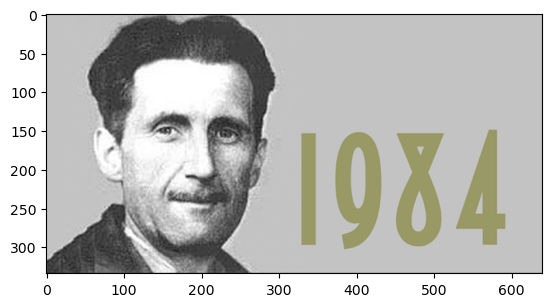

Use as thumbnail? Y or N: n


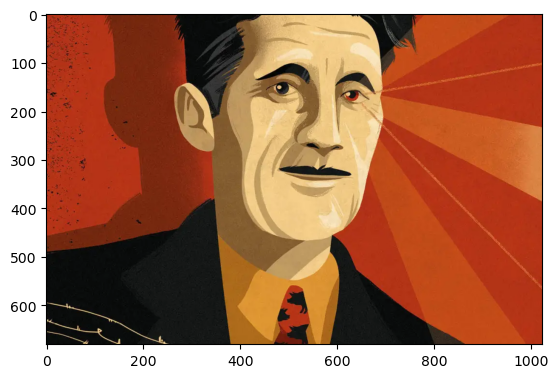

Use as thumbnail? Y or N: n


/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_54127/3632005658.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_image = selected_image.resize((w, h), Image.ANTIALIAS)
/var/folders/xx/hy496x3x5sn4hy9gy1fk19lw0000gp/T/ipykernel_54127/3632005658.py:50: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  selected_image = selected_image.resize((w, h), Image.ANTIALIAS)


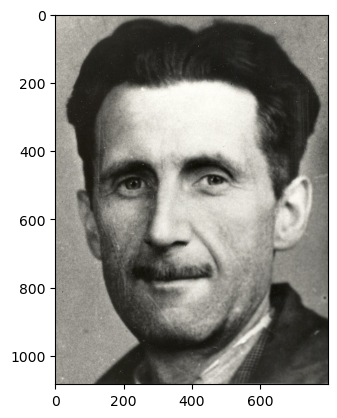

Use as thumbnail? Y or N: y


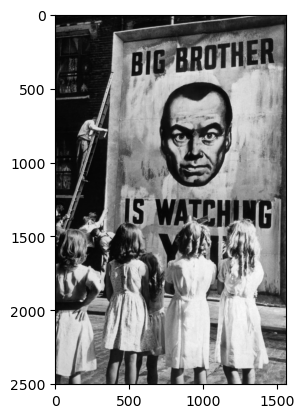

Use as thumbnail? Y or N: n


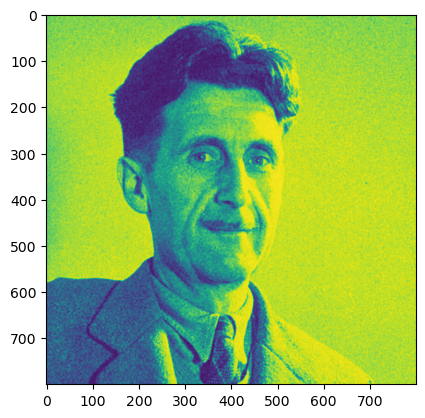

Use as thumbnail? Y or N: y


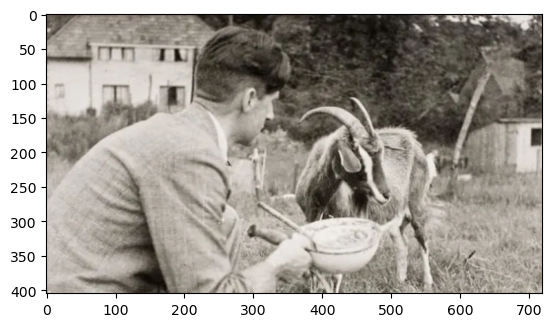

Use as thumbnail? Y or N: n


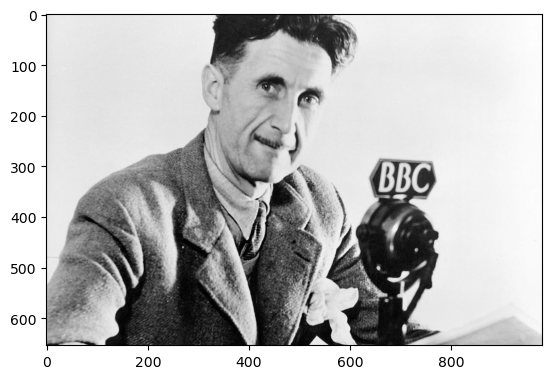

Use as thumbnail? Y or N: n


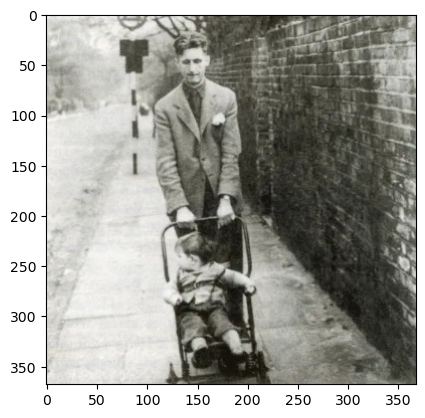

Use as thumbnail? Y or N: n


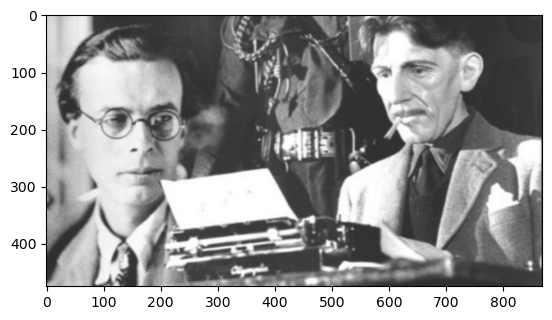

Use as thumbnail? Y or N: n


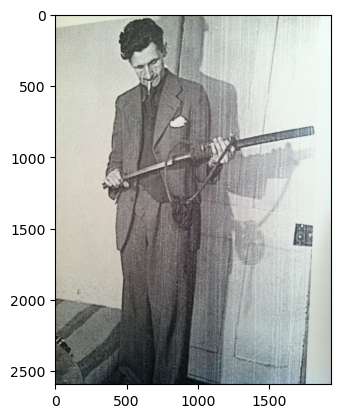

Use as thumbnail? Y or N: n


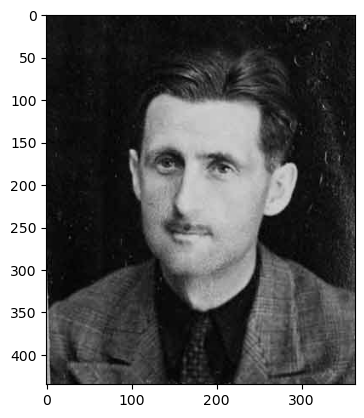

Use as thumbnail? Y or N: y


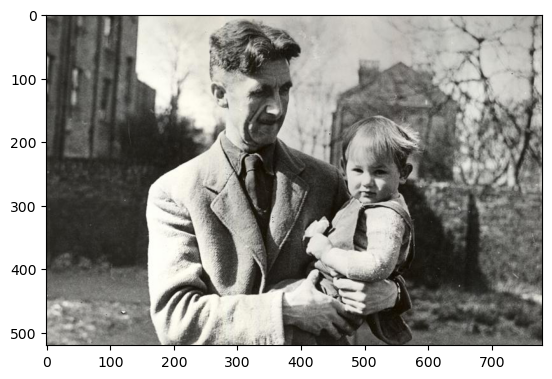

Use as thumbnail? Y or N: n


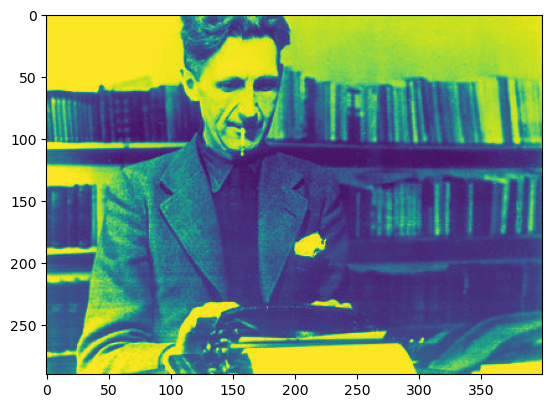

Use as thumbnail? Y or N: n


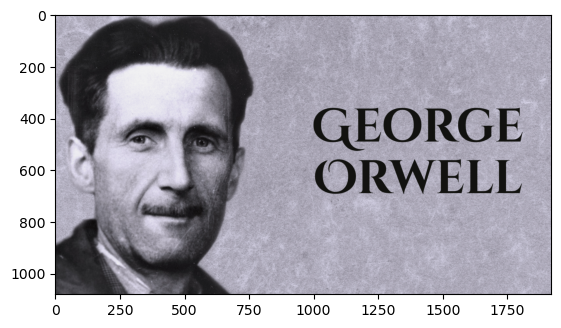

Use as thumbnail? Y or N: n


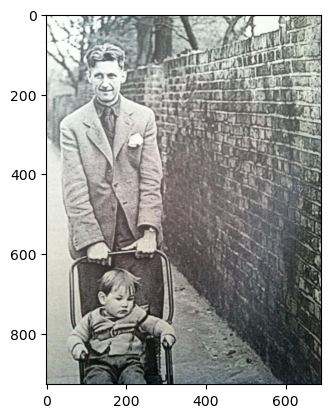

Use as thumbnail? Y or N: n


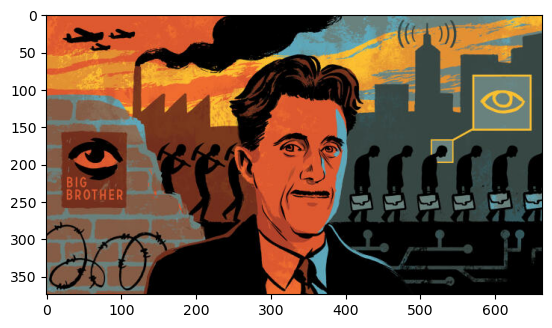

Use as thumbnail? Y or N: n


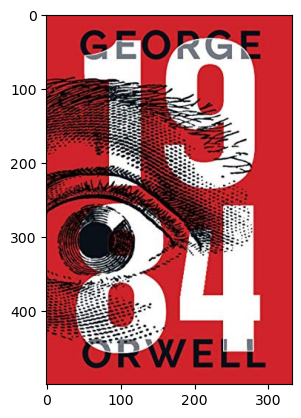

Use as thumbnail? Y or N: n


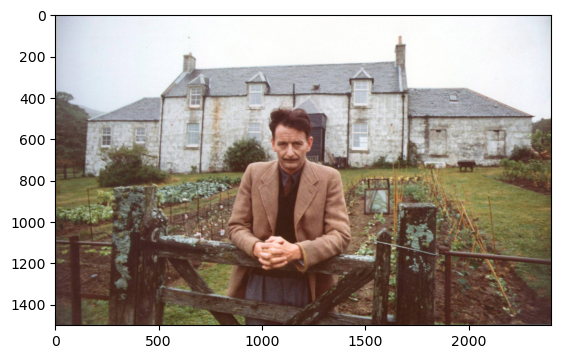

Use as thumbnail? Y or N: n
All Done Laa!


In [161]:
convert_images_from_folder('George Orwell')

If there are no images for any figures which have audio complete then we need to find some imgaes. To do this we will use Selenium and google image search for each figure. We then will loop through images and allow the user to reply y/n until 10 images have been selected.

# We only do this if images are needed
if need_images.shape[0] > 0:
    
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    # Get the dominant colour of the image
    from colorthief import ColorThief
    #from selenium.webdriver.common.keys import Keys
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    quality_val = 90
    # Loop a google images search across figures.
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + figure
        
        # Create the figure directory to save the images if needed
        isExist = os.path.exists(image_path)
        if not isExist:
            os.makedirs(image_path)
        
        #----GOOGLE IMAGE SEARCH CODE----#
        
        # What you enter here will be searched for in Google Images
        query = figure

        #desired_dpi = 2.0
        #options = Options()
        #options.add_argument(f"--force-device-scale-factor={desired_dpi}")
        # Creating a webdriver instance
        driver = webdriver.Chrome()

        # Maximize the screen
        driver.maximize_window()

        # Open Google Images in the browser
        driver.get('https://images.google.com/')

        # Clear cookies - INSPECT and then use click option then copy xpath
        driver.find_element('xpath', '//*[@id="L2AGLb"]').click()

        # Finding the search box - INSPECT and then use click option then copy xpath
        box = driver.find_element("xpath", '//*[@id="APjFqb"]')

        # Type the search query in the search box
        box.send_keys(query)

        # Pressing enter
        #box.send_keys(Keys.ENTER)
        
        # click the search button - INSPECT and then use click option then copy xpath
        driver.find_element('xpath', '/html/body/div[1]/div[3]/form/div[1]/div[1]/div[1]/button').click()
        
        # Now we want to loop across the images to let user selected whether to keep or not
        i = 1
        images_kept = 0
        thumbnail_options = 1
        while images_kept < 10:
            # Here i represents the image shown on the screen - want to click it to expand
            driver.find_element('xpath','//*[@id="islrg"]/div[1]/div[' + str(i) + ']/a[1]/div[1]/img').click()

            # Get the image aspect of the expanded image - INSPECT and then use click option then copy xpath
            imgResults = driver.find_element('xpath',
                                             '//*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]')
            
            # //*[@id="Sva75c"]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]
            # /html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]
            # Save the image
            imgResults.screenshot('test.png')

            # Load as image object
            selected_clicked_image = Image.open('test.png')

            # This plots the image so we can see it
            %matplotlib inline
            import matplotlib.pyplot as plt
            import matplotlib.image as mpimg
            img = mpimg.imread('test.png')
            imgplot = plt.imshow(img)
            plt.show()
    
            # Text to display to give option of saving image
            keep = input(figure + " Image " + str(images_kept + 1) + " - Keep this image? Y or N: ")
    
            # If keep then save the image and increment
            if keep == "Y" or keep == "y":
                
                # Text to whether i want to save the image as a thumbnail option
                thumbnail = input("Use as thumbnail? Y or N: ")
                
                if thumbnail == "Y" or thumbnail == "y":
                    selected_clicked_image.save(image_path + "/thumbnail" + str(thumbnail_options) + ".png", 
                                                quality=quality_val)
                    thumbnail_options += 1
                
                # We want all images to be the same size. If they aren't resize them.
                h = selected_clicked_image.height
                w = selected_clicked_image.width
                
                if h > 480:
                    h = 480
                    selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
                if w > 720:
                    w = 720
                    selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)

                start_pos_w = 360 - w/2
                start_pos_h = 240 - h/2
 
                # Want to paste the resized image onto dominant colour background
                color_thief = ColorThief('test.png')
                # get the dominant color
                dominant_color = color_thief.get_color(quality=1)
                # Background
                bk = Image.new('RGB', (720, 480), color = dominant_color)
                # paste background image on to border image
                bk.paste(selected_clicked_image, (int(start_pos_w), int(start_pos_h)))
                
                bk.save(image_path + "/" + str(images_kept + 1) + '.png',
                       quality=quality_val)
                
                images_kept += 1
    
            i += 1
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        # Remove the test image
        os.remove('test.png')
        
        # Close the driver
        driver.minimize_window()
        driver.close()

    

## Manual Image Adding

def manual_image_generator(image_location, figure, image_number,
                          thumbnail_num = 0, images_complete = False):

    image_path = images_loc + figure
    
    quality_val = 90
        
    # Create the figure directory to save the images if needed
    isExist = os.path.exists(image_path)
    if not isExist:
        os.makedirs(image_path)
        
    #----GOOGLE IMAGE SEARCH CODE----#
    save_location = image_path + "/" + str(image_number) + ".png"
    # Load as image object
    selected_clicked_image = Image.open(image_location)
                
    if thumbnail_num > 0:
        selected_clicked_image.save(image_path + "/thumbnail" + str(thumbnail_num) + ".png", 
                                                quality=quality_val)
                
    # We want all images to be the same size. If they aren't resize them.
    h = selected_clicked_image.height
    w = selected_clicked_image.width
                
    if h > 480:
        h = 480
        selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)
    if w > 720:
        w = 720
        selected_clicked_image = selected_clicked_image.resize((w, h), Image.ANTIALIAS)

    start_pos_w = 360 - w/2
    start_pos_h = 240 - h/2
 
    # Want to paste the resized image onto dominant colour background
    color_thief = ColorThief(image_location)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)
    # Background
    bk = Image.new('RGB', (720, 480), color = dominant_color)
    # paste background image on to border image
    bk.paste(selected_clicked_image, (int(start_pos_w), int(start_pos_h)))
                
    bk.save(save_location, quality=quality_val)
        
    # Remove the test image
    os.remove(image_location)
    
    if images_complete == True:
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
   

manual_image_generator('/Users/user/Documents/GitHub/Video-from-Script/Images/Frida Kahlo/Lola-Alvarez-Bravo-Arturo-Estrada-and-Frida-Kahlo-in-Exhibition_web_0.jpg',
                      'Frida Kahlo',
                      14, images_complete = True)

## Add Video

Next we wish to check if any figures have a script, an audio and images available but there is no video recorded. If this is the case then the code will loop through the figures and combine the audio and images together to create a vide and save it in the Video folder before finally adjusting the table to show this.

In [226]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We will grab any figures who have a script and audio complete but no video.
need_video = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "No")]

In [227]:
need_video

Empty DataFrame
Columns: [Figure_ID, Name, Description, Script_Created, AI_Voice_Generated, Images_Obtained, Youtube_Video_Created, Youtube_Video_Posted, Youtube_URL, Prompt]
Index: []

In [228]:
if need_video.shape[0] > 0:
    from moviepy.editor import *
    os.environ["IMAGEIO_FFMPEG_EXE"] = "ffmpeg"
    # Get the figures who need a video making
    figure_video = list(need_video.iloc[:,1].values)
    
    for figure in figure_video:
        # Get the locations
        audio_location = audio_loc + figure + '.mp3'
        image_location = images_loc + figure + '/'
        video_location = video_loc + figure + '.mp4'
        
        # Add audio clip and get the duration
        audio_clip = AudioFileClip(audio_location)
        audio_duration = audio_clip.duration
        
        # Get the time each image will show for, remove thumbnail options
        possible_images = os.listdir(image_location)
        possible_images = [image for image in possible_images if "thumbnail" not in image]
        possible_images = [ i for i in possible_images if i != '.DS_Store']
        
        number_of_images = len(possible_images)
        image_duration = audio_duration / number_of_images

        # Here we create the frames for each image and their duration
        img_names = possible_images
        img = list(image_location + img for img in img_names)

        clips = [ImageClip(m).set_duration(image_duration)
                 for m in img]

        # Combine the images together into a single clip
        concat_clip = concatenate_videoclips(clips, method = "compose")

        # add the audio
        concat_clip.audio = audio_clip

        # Write the video with audio included
        concat_clip.write_videofile(video_location, fps = 24)

        # Add Yes to the video created column
        historical_figures_list.iloc[(historical_figures_list.Name == figure),6] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## Functions for Youtube Upload

Here are the functions used in the upload process

In [229]:
def create_description(string, string_to_replace, figure):
    # Create YouTube description
    modified_string = string.replace(string_to_replace, figure)
    return(modified_string)

In [230]:
def move_video(figure):
    # We want to move the video to the main file directory
    import shutil
    video_location = video_loc + figure + '.mp4'
    shutil.copy2(video_location, "video.mp4")

In [230]:
def thumbnail_generator(image_location, title_text, YT_logo_location, YT_channel,
                       font_location, save_location):

    # Add image as an object
    my_image = Image.open(image_location)

    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    my_image.thumbnail(max_image_size)

    ### PROFILE PICTURE IN CORNER ###
    # Add the youtube profile picture
    profile_pic = Image.open(YT_logo_location).convert("RGBA")
    # Add random background, doesn't matter what
    background = Image.new("RGBA", profile_pic.size, (0,0,0,0))

    mask = Image.new("RGBA", profile_pic.size, 0)
    draw = ImageDraw.Draw(mask)
    
    # Crop the circle
    draw.ellipse((0,0,int(profile_pic.size[0]),int(profile_pic.size[0])),
                 fill='green', outline=None)

    # Make the image
    profile_pic = Image.composite(profile_pic, background, mask)

    # resize profile pic
    profile_pic = profile_pic.resize((200, 200))

    ### GET DOMINANT COLOUR FOR BACKGROUND AND TEXT COLOUR ###
    
    # Get the dominant colour of the image
    from colorthief import ColorThief
    color_thief = ColorThief(image_location)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)

    # To get whether text will be white or black
    if (0.299 * dominant_color[0]) + (0.587 * dominant_color[1]) + (0.114 * dominant_color[2]) > 186:
        contrast_colour = tuple([0, 0, 0])
    else: 
            contrast_colour= tuple([255, 255, 255])

    ### PASTE IMAGES TOGETHER ###
    
    # Sizing down image 
    my_image = my_image.resize((int(500), 680))

    # Create background and add the border and background image
    # Border
    img = Image.new('RGB', (1280, 720), color = contrast_colour)
    # Background
    img2 = Image.new('RGB', (1260, 700), color = dominant_color)
    # paste background image on to border image
    img.paste(img2, (10, 10))
    # Add my image on top
    img.paste(my_image, (20, 20))
    # Add the profile pic
    img.paste(profile_pic, (1060, 500), mask = profile_pic)

    ### FONTSIZE GENERATOR ###
    
    # Get the text for the title
    title_text = title_text
    
    fontsize = 1  # starting font size
    # Get the font and initialise the size
    font = ImageFont.truetype(font_location, fontsize)
    # Remaining size of image
    breakpoint = 720
    # Large jumps to speed up process
    jumpsize = 75

    # Loops through fontsizes and finds the max which fits all of the text
    while True:
        if font.getsize(title_text)[0] < breakpoint:
            fontsize += jumpsize
        else:
            jumpsize = jumpsize // 2
            fontsize -= jumpsize
        font = ImageFont.truetype(font_location, fontsize)
        if jumpsize <= 1:
            break

    # This returned huge font for small number of characters so workaround in place
    # This was done with trial and error
    if fontsize > 190:
        fontsize = 190
        font = ImageFont.truetype(font_location, fontsize)
        subtitle_size = int(fontsize / 2)
        start_pos = -20
        subtitle_start = 160
    elif fontsize <= 100:
        subtitle_size = 90
        start_pos = 20
        subtitle_start = 50 + int(fontsize / 2)
    else:
        subtitle_size = int(fontsize / 2)
        start_pos = - 10
        subtitle_start = 80 + int(fontsize / 2)

    # Allow for drawing on the image
    image_editable = ImageDraw.Draw(img)

    # Add the title
    image_editable.text((540, start_pos), title_text, contrast_colour, font = font)

    # Add the subtitle
    title_font = ImageFont.truetype(font_location, subtitle_size )
    title_text = "10 Interesting Facts"
    image_editable.text((540, subtitle_start), title_text, contrast_colour, font = title_font)

    # Add the youtube handle
    title_font = ImageFont.truetype(font_location, 40)
    title_text = YT_channel
    image_editable.text((540, 655), title_text, contrast_colour, font = title_font)

    img.save(save_location)
    # img.show()

    # This plots the image so we can see it
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(save_location)
    imgplot = plt.imshow(img)
    plt.show()
    


## Youtube Preparation

In [231]:
def YouTube_preparation(historical_figure):
    move_video(historical_figure)
    print("#--------------------TITLE--------------------#\n")
    print(historical_figure, "- 10 Interesting Facts\n")
    print("#-----------------DESCRIPTION-----------------#\n")
    create_description(description, "[Historical Figure]", historical_figure)
    print("\n")
    
    # Images for tumbnail function
    image_location = images_loc + historical_figure + "/"
    all_images = os.listdir(image_location)
    thumbnails = [x for x in all_images if x.startswith('t')]
    thumbnails.sort()
    
    option = 1
    for thumbnail in thumbnails:
        
        print_option = "#-----------------THUMBNAIL " + str(option) + "-----------------#\n"
        print(print_option)
        
        save_location = "./Thumbnails/" + historical_figure + "-" + thumbnail
        thumbnail_generator(image_location = image_location + thumbnail,
                            title_text = historical_figure,
                            YT_logo_location = 'YT Profile.jpg',
                            YT_channel = "@Figures_In_History",
                            font_location = "./Fonts/Bebas-Regular.ttf",
                            save_location = save_location)
        option += 1
    
    i = 0
    while i == 0:
        string = "Choose which thumbnail you would like to use: 1 to " + str(len(thumbnails))
        thumbnail_choice = input(string)
          
        if int(thumbnail_choice) > len(thumbnails):
            i = 0
        else:
            file_loc = "./Thumbnails/" + historical_figure + "-" + "thumbnail" + thumbnail_choice + ".png"
            shutil.copy(file_loc, "thumbnail.png")
            i = 1

In [232]:
import os
import pandas as pd
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from google_auth_oauthlib.flow import InstalledAppFlow

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "YouTube API Credentials.json"

# Authenticate and build the YouTube API client
flow = InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_local_server(port=0)
youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

# Retrieve your channel's information to get the uploads playlist ID
request = youtube.channels().list(part="contentDetails", mine=True)
response = request.execute()

# Get the uploads playlist ID
uploads_playlist_id = response["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]

# Fetch videos from the uploads playlist
private_videos = []
next_page_token = None

while True:
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=uploads_playlist_id,
        maxResults=50,  # Adjust as needed
        pageToken=next_page_token
    )
    response_playlist = request.execute()

    video_ids = [item['contentDetails']['videoId'] for item in response_playlist['items']]
    
    if video_ids:
        request_videos = youtube.videos().list(
            part="snippet,status",
            id=','.join(video_ids)
        )
        response_videos = request_videos.execute()
        
        for item in response_videos["items"]:
            if item["status"]["privacyStatus"] == "private":
                video_data = {
                    "Title": item["snippet"]["title"],
                    "Video ID": item["id"],
                    "Publish Date": item["snippet"]["publishedAt"],
                    "Scheduled Date": item["status"].get("publishAt", "Not Scheduled")
                }
                private_videos.append(video_data)

    next_page_token = response_playlist.get("nextPageToken")
    if not next_page_token:
        break

# Create a DataFrame
df_private_videos = pd.DataFrame(private_videos)

# Ensure the 'Scheduled Date' column is in datetime format
df_private_videos['Scheduled Date'] = pd.to_datetime(df_private_videos['Scheduled Date'], errors='coerce')

# Sort the DataFrame by 'Scheduled Date' in descending order
df_private_videos_sorted = df_private_videos.sort_values(by='Scheduled Date', ascending=False)

# Select the latest scheduled video
latest_scheduled_video = df_private_videos_sorted.iloc[0]

# Extract just the date from the 'Scheduled Date' of the latest video
latest_scheduled_date = latest_scheduled_video['Scheduled Date'].date()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=837999920303-to0oms8geiv884s9hpt1qog77v1sivq1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A58012%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=3P8rqWfeeY0cG7fDjgMqORGpXAXZZC&access_type=offline


In [235]:
from pandas.tseries.offsets import Day
from datetime import datetime, timedelta

# Define your start and end dates
start_date = latest_scheduled_date
end_date = latest_scheduled_date + timedelta(days = 365)

# Generate date range
dates = pd.date_range(start=start_date, end=end_date, freq=Day())

# Create DataFrame
date_table = pd.DataFrame({'Date': dates})
date_table['Weekday'] = date_table['Date'].dt.weekday
# Add a fixed time (12:00:00) to each date and convert to UTC Timestamp
date_table['Timestamp_UTC'] = pd.to_datetime(date_table['Date'].apply(lambda d: d.replace(hour=12, minute=0, second=0)))

# Filter for Monday (0), Wednesday (2), and Friday (4)
date_table = date_table[date_table['Weekday'].isin([0, 2, 4])]

# Remove the top row as that video is already uploaded
date_table = date_table.iloc[1:]

In [236]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')
# We will grab any figures who have a script and audio complete but no video.
need_upload = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "Yes") &
                                    (historical_figures_list.Youtube_Video_Posted == "No")]

def sample_rows(df, sample_size=10):
    
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input is not a valid DataFrame")
    
    row_count = len(df)
    
    # If the DataFrame has less than 10 rows or the sample_size is less than 10
    if row_count < 10 or (sample_size < 10 and sample_size > 0):
        sample_size = min(row_count, sample_size)
    
    return df.sample(n=sample_size)

need_upload = sample_rows(need_upload)

In [237]:
need_upload

Figure_ID    Name                                        Description  \
98         99  Banksy  Romanian gymnast, first to score a perfect 10 ...   

   Script_Created AI_Voice_Generated Images_Obtained Youtube_Video_Created  \
98            Yes                Yes             Yes                   Yes   

   Youtube_Video_Posted Youtube_URL  \
98                   No         NaN   

                                               Prompt  
98  Please provide me with 10 long and interesting...

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=837999920303-to0oms8geiv884s9hpt1qog77v1sivq1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A57818%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.upload&state=apd35QKqzcBRnwKGO0VtUSF2eF623d&access_type=offline
#-----------------THUMBNAIL 1-----------------#



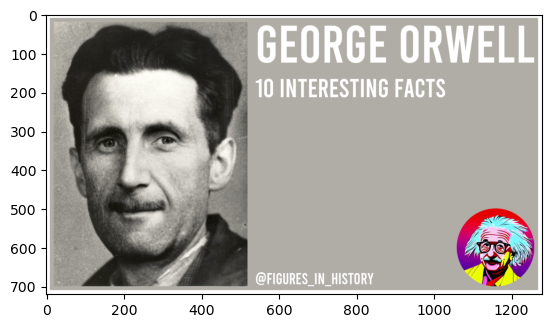

#-----------------THUMBNAIL 2-----------------#



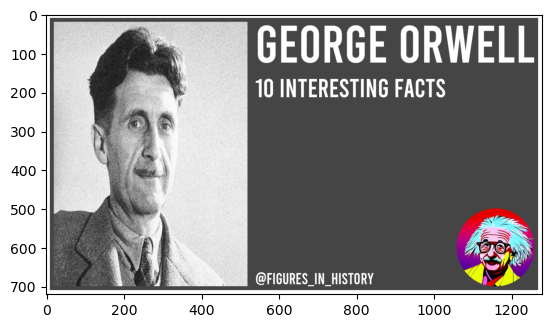

#-----------------THUMBNAIL 3-----------------#



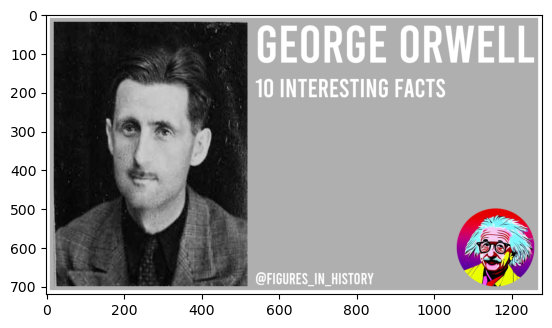

Choose which thumbnail you would like to use: 1 to 31
George Orwell Video Uploaded
#-----------------THUMBNAIL 1-----------------#



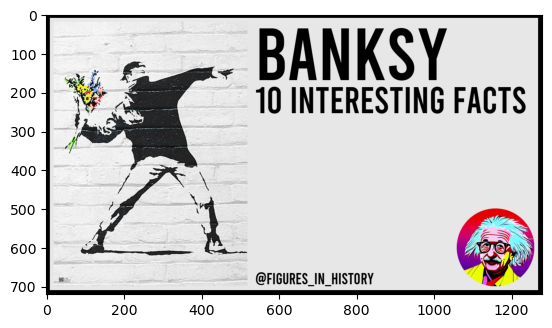

Choose which thumbnail you would like to use: 1 to 11


ResumableUploadError: <HttpError 403 when requesting None returned "The request cannot be completed because you have exceeded your <a href="/youtube/v3/getting-started#quota">quota</a>.". Details: "[{'message': 'The request cannot be completed because you have exceeded your <a href="/youtube/v3/getting-started#quota">quota</a>.', 'domain': 'youtube.quota', 'reason': 'quotaExceeded'}]">

In [195]:
if need_upload.shape[0] > 0:
    
    import os
    import io
    import google_auth_oauthlib.flow
    import googleapiclient.discovery
    import googleapiclient.errors
    from googleapiclient.http import MediaFileUpload
    from google_auth_oauthlib.flow import InstalledAppFlow
    from datetime import datetime
    
    # Disable OAuthlib's HTTPS verification when running locally.
    # DO NOT leave this option enabled in production.
    os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    client_secrets_file = "YouTube API Credentials.json"
    scopes = ["https://www.googleapis.com/auth/youtube.upload"]

    # Get credentials and create an API client
    flow = InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
    credentials = flow.run_local_server(port=0)
    youtube = googleapiclient.discovery.build(api_service_name, api_version, credentials=credentials)

    images_loc = "./Images/"
    
    # Get the figures who need a video making
    figure_upload = list(need_upload.iloc[:,1].values)
    
    for figure in figure_upload:
        move_video(figure)
        
        schedule_date = date_table.iloc[figure_upload.index(figure),2]
        # Convert to desired format
        schedule_date = schedule_date.strftime("%Y-%m-%dT%H:%M:%SZ")
        
        title = figure + " - 10 Interesting Facts"
        
        yt_desc = create_description(description, "[Historical Figure]", figure)
 
        
        # Images for tumbnail function
        image_location = images_loc + figure + "/"
        all_images = os.listdir(image_location)
        thumbnails = [x for x in all_images if x.startswith('t')]
        thumbnails.sort()
    
        option = 1
        for thumbnail in thumbnails:
        
            print_option = "#-----------------THUMBNAIL " + str(option) + "-----------------#\n"
            print(print_option)
        
            save_location = "./Thumbnails/" + figure + "-" + thumbnail
            thumbnail_generator(image_location = image_location + thumbnail,
                                title_text = figure,
                                YT_logo_location = 'YT Profile.jpg',
                                YT_channel = "@Figures_In_History",
                                font_location = "./Fonts/Bebas-Regular.ttf",
                                save_location = save_location)
            option += 1
    
        i = 0
        while i == 0:
            string = "Choose which thumbnail you would like to use: 1 to " + str(len(thumbnails))
            thumbnail_choice = input(string)
          
            if int(thumbnail_choice) > len(thumbnails):
                i = 0
            else:
                file_loc = "./Thumbnails/" + figure + "-" + "thumbnail" + thumbnail_choice + ".png"
                shutil.copy(file_loc, "thumbnail.png")
                i = 1
        
        # Specify the file path for your video and thumbnail
        video_file = "video.mp4"
        thumbnail_file = "thumbnail.png"

        # Create the request
        request_body = {
            "snippet": {
                "categoryId": "22",  # You can change this to the appropriate category
                "title": title,
                "description": yt_desc #,
                #"tags": ["tag1", "tag2"]  # Add relevant tags
            },
            "status": {
                "privacyStatus": "private",  # Must be private for scheduling
                "publishAt": schedule_date,  # Scheduled publishing time (UTC)
                "madeForKids": False  # Not made for kids
            }
        }

        # Call the API to upload the video
        media_file = MediaFileUpload(video_file, chunksize=-1, resumable=True)
        response_upload = youtube.videos().insert(
            part="snippet,status",
            body=request_body,
            media_body=media_file
        ).execute()

        # Call the API to upload the thumbnail
        youtube.thumbnails().set(
            videoId=response_upload.get("id"),
            media_body=MediaFileUpload(thumbnail_file)
        ).execute()

        # Get the video ID from the response
        video_id = response_upload.get("id")

        # Construct the video URL
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        
        # Change the image obtained to yes for the specified figure and save
        historical_figures_list.iloc[(historical_figures_list.Name == figure),7] = "Yes"
        historical_figures_list.iloc[(historical_figures_list.Name == figure),8] = video_url
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
        print(f"{figure} Video Uploaded")
    
    print("All Done Laa!")